In [1]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2,decode_predictions,preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint , EarlyStopping

In [2]:
import my_utils
import numpy as np
from my_utils.my_utils import create_generator, LossHistory
from IPython.display import clear_output
import importlib
importlib.reload(my_utils)
import matplotlib.pyplot as plt
from PIL import Image

In [3]:
base_model = MobileNetV2(input_shape=(224,224,3),weights='imagenet', include_top=False)

In [4]:
output = "scores"
#output = "labels"

In [5]:
counter = 0
batch_size = 100
size = 1500
X = np.ndarray(shape=(0,224,224,3))
Y = np.ndarray(shape=(0,))
for _X,_Y in create_generator(output=output,batch_size=batch_size):
    X = np.concatenate([X,_X])
    Y = np.concatenate([Y,_Y])
    counter +=1
    if counter == size/batch_size:
        break

        
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size = 0.2)

In [6]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.7)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='linear')(x)

In [7]:
model = Model(inputs=base_model.input, outputs=predictions)
for layer in base_model.layers:
    layer.trainable = False
opt=Adam()
model.compile(optimizer=opt, loss='mean_absolute_percentage_error')

In [8]:
model_name = "mob2fit{}scores".format(size)

In [9]:
history = model.fit(x=X_train,y=Y_train,epochs=60,batch_size=32,validation_split=0.2)

Train on 960 samples, validate on 240 samples
Epoch 1/60
224/960 [======>.......................] - ETA: 1:00 - loss: 92.6291

KeyboardInterrupt: 

In [10]:
model.evaluate(x=X_test,y=Y_test)

300/300 [==============================] - 19s 63ms/sample - loss: 68.0758


68.07577382405599

In [11]:
Y_pred = model.predict(X_test)

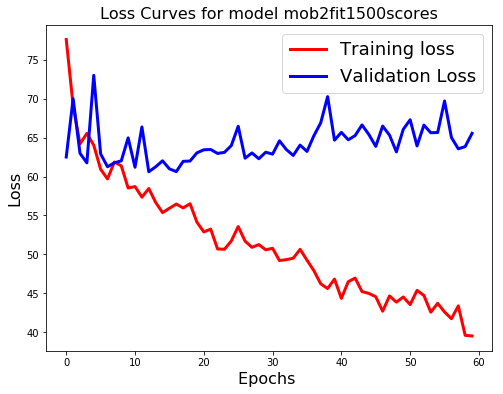

In [25]:
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'][0:],'r',linewidth=3.0)
plt.plot(history.history['val_loss'][0:],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves for model {}'.format(model_name),fontsize=16)
#plt.savefig("../pictures/{}.jpg".format(model_name))

In [27]:
#model.save("../models/{}60ep".format(model_name))

In [78]:
# import json
# import os
# path = "../models/{}.json".format(model_name)
# exists = os.path.isfile(path)
# if not exists:
#     with open(path,"w") as f:
#         json.dump(history.history,f)
# else:
#     my_dict = history.history.copy()
#     with open(path,"r") as f:
#         old_dict = json.load(f)
#     for key in old_dict.keys():
#         my_dict[key] = old_dict[key]+my_dict[key]
#     with open(path,"w") as f:
#         json.dump(my_dict,f)